In [1]:
## These are the liberaries used to run LSTM Model. 
## Keras lib provides accruate results in Machine learning. LSTM is the predictive model 
## MinMaxScaler is for transform the attribute values in between 0 and 1
## RMSE is used for evaluate the error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
## Reading the household Power consumption file, which is already cleaned with missing values.
## Choosing index column as date_time because it is Time series data set
## Its is having dates so parse dates is true
## Its a large file so low memory is false 

df = pd.read_csv('Preprocessed data.csv', parse_dates= True, index_col = 'date_time', low_memory = False )



In [3]:
## head displays the of the data set.

df.head()



,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.shape

(2075259, 7)

# Preparing LSTM MODEL 

In [5]:
## This involves framing the dataset as supervised learning problem and normalizing the input variables
## Framing the supervised learning problem as predicting the power consumption at current hour (t)
## Predicting the power consumption for the next hour based on the power consumption over last 24 hrs 


In [6]:
## Convert series to supervised learning 

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    ## input sequence (t-n,.....t-1)
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    ## forecast sequence (t, t+1,....t+n)    
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
    
    ## put it all together 
    
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        
    ## Drop rows with NAN values     
    
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [39]:
df_resample = df.resample('h').mean()
df_resample.shape

(34951, 7)

In [40]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [41]:
## values returns a list of all the values in the data frame
values = df_resample.values

In [42]:
## Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

In [43]:
## calculating scaler using fit_transform fn for values and assigning it as scaled 
scaled = scaler.fit_transform(values)

In [44]:
## Called series_to_supervised fn to make it as supervised learning 
reframed = series_to_supervised(scaled, 1, 1)


In [45]:
## Droping the other columns because we are Predicting only for Global active power
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)


In [46]:
## Reframed head 
## This prints the first five rows of transformed dataset. We can see the 8 input variables( input series )
## The 1 output variable at the current hour that is var1(t)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597


## Define and Fit model 

In [47]:
## Fit an LSTM model on the multivariate input dat.
## First, Splitting the prepared data sets into train and test sets.
## To speed up the training model, fit the model on the first year of data,then evaluate on the remaining 3 years of data.
## Splits the dataset into train and test tests, then splits the train and test sets into input and output variables.
## Then input(X) are reshaped into 3D format expected by LSTMs namley [samples,timesteps,features]


In [48]:
## split into train and test sets 

values = reframed.values
n_train_hours = 365*24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [49]:
## split into input and outputs 

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

In [50]:
## reshape input to be 3D 

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


In [51]:
## Prints the shape of input of the train and test input and output about 9k hours for training and 26k hours for testing.

print(train_x.shape, train_y.shape,test_x.shape, test_y.shape )

(8760, 1, 7) (8760,) (25816, 1, 7) (25816,)


# Fit our LSTM Model 


In [52]:
## Define LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting power consumption.
## The input shape will 1 time step with 8 features 
## Using Mean Absolute error(MAE) loss function and the efficient adam version stochastic gradient descent 
## The model will be fit for 20 training epchos with a batch size of 70. 
## Tracking the training and test loss during training by setting the validation_data argument in the fit() fn.
## Plotting the training and test loss are plotted 

Epoch 1/20
110/110 - 2s - loss: 0.0201 - val_loss: 0.0107
Epoch 2/20
110/110 - 1s - loss: 0.0127 - val_loss: 0.0101
Epoch 3/20
110/110 - 1s - loss: 0.0122 - val_loss: 0.0097
Epoch 4/20
110/110 - 1s - loss: 0.0117 - val_loss: 0.0094
Epoch 5/20
110/110 - 1s - loss: 0.0116 - val_loss: 0.0092
Epoch 6/20
110/110 - 1s - loss: 0.0114 - val_loss: 0.0091
Epoch 7/20
110/110 - 1s - loss: 0.0114 - val_loss: 0.0091
Epoch 8/20
110/110 - 1s - loss: 0.0113 - val_loss: 0.0091
Epoch 9/20
110/110 - 1s - loss: 0.0113 - val_loss: 0.0090
Epoch 10/20
110/110 - 1s - loss: 0.0113 - val_loss: 0.0090
Epoch 11/20
110/110 - 1s - loss: 0.0113 - val_loss: 0.0090
Epoch 12/20
110/110 - 1s - loss: 0.0112 - val_loss: 0.0090
Epoch 13/20
110/110 - 1s - loss: 0.0112 - val_loss: 0.0090
Epoch 14/20
110/110 - 1s - loss: 0.0112 - val_loss: 0.0089
Epoch 15/20
110/110 - 1s - loss: 0.0113 - val_loss: 0.0089
Epoch 16/20
110/110 - 1s - loss: 0.0112 - val_loss: 0.0089
Epoch 17/20
110/110 - 1s - loss: 0.0111 - val_loss: 0.0089
Epoch 

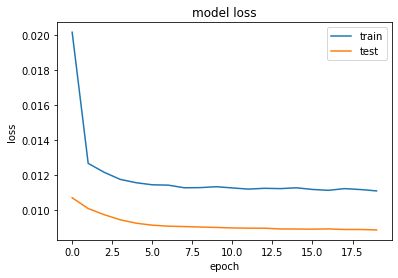

In [53]:
## design network 
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# fit network
history = model.fit(train_x, train_y, epochs=20, batch_size=80, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# Evaluate Model 
## After the model is fit, we can forecast the entire test dataset

In [22]:
## Combine the forecast with the test data set and invert scaling.
## Invert scaling on the test dataset with the exxpected power consumption numbers.
## With forecasts and actual values in their scale, Calcuation of an error is made. 
## For this we calculate RMSE( Root mean squared error) that gives error in the same units as the variable itself.

In [55]:
# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 7))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_x[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.606


# Plotting Actual vs Predicted 

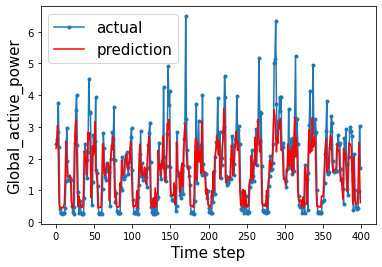

In [34]:
px=[x for x in range(400)]
plt.plot(px, inv_y[:400], marker='.', label="actual")
plt.plot(px, inv_yhat[:400], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


In [58]:
print('LSTM:\n')
print('Mean Absolute Error:',metrics.mean_absolute_error(inv_y,inv_yhat))
print('Mean Squared Error:',metrics.mean_squared_error(inv_y,inv_yhat))
print('Root Mean Squared Error:',np.sqrt(metrics.mean_squared_error(inv_y,inv_yhat)))

LSTM:

Mean Absolute Error: 0.4313320696777696
Mean Squared Error: 0.3672323739393553
Root Mean Squared Error: 0.605997008193403


In [63]:
df_actual = pd.DataFrame({'Actual': inv_y})

In [65]:

predict_ser=pd.Series(inv_yhat.reshape(25816,))

In [66]:
df1_result=pd.concat([df_actual,predict_ser],axis=1)

In [67]:
df1_result

,Actual,0
0,2.474967,2.291118
1,2.626633,2.406498
2,2.834200,3.020151
3,3.767167,2.154347
4,2.361233,0.580800
...,...,...
25811,2.280867,2.006446
25812,2.391967,1.585481
25813,1.753333,1.145592
25814,1.114900,0.466473


In [68]:
df1_result.columns=['Actual','Predicted']
df1_result

,Actual,Predicted
0,2.474967,2.291118
1,2.626633,2.406498
2,2.834200,3.020151
3,3.767167,2.154347
4,2.361233,0.580800
...,...,...
25811,2.280867,2.006446
25812,2.391967,1.585481
25813,1.753333,1.145592
25814,1.114900,0.466473


In [70]:
df1_result.to_csv('Actaul and predicted numerical values for an hour prediction.csv')